In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor
from torch import nn

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
transform = ToTensor()

mnist_train = torchvision.datasets.MNIST(root="data", train=True, transform=transform, target_transform=None, download=True)
mnist_test = torchvision.datasets.MNIST(root="data", train=False, transform=transform, target_transform=None, download=True)

mnist_train, mnist_test

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [3]:
train_DataLoader = DataLoader(dataset=mnist_train, batch_size=32, shuffle=True)
test_DataLoader = DataLoader(dataset=mnist_test, batch_size=32, shuffle=True)

train_DataLoader, test_DataLoader

(<torch.utils.data.dataloader.DataLoader at 0x12248ea50>,
 <torch.utils.data.dataloader.DataLoader at 0x12246e0d0>)

In [4]:
X0, y0 = next(iter(train_DataLoader))
X0.shape, y0.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [5]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [6]:
mnist_train.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [7]:
class SimpleAE(nn.Module):
    def __init__(self, input_features, encoder_hidden_features, latent_dim, decoder_hidden_features, output_features):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=encoder_hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=encoder_hidden_features, out_features=latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=decoder_hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=decoder_hidden_features, out_features=output_features),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch = x.shape[0]
        x = x.view(batch, -1)
        return self.decoder(self.encoder(x))
    
autoencoder0 = SimpleAE(input_features=28*28, encoder_hidden_features=256, latent_dim=64, decoder_hidden_features=256, output_features=28*28)
autoencoder0.to(device=device)

autoencoder0, next(autoencoder0.parameters()).device, autoencoder0.state_dict()

(SimpleAE(
   (encoder): Sequential(
     (0): Linear(in_features=784, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=64, bias=True)
     (3): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=64, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=784, bias=True)
     (3): Sigmoid()
   )
 ),
 device(type='mps', index=0),
 OrderedDict([('encoder.0.weight',
               tensor([[ 0.0206, -0.0050,  0.0276,  ...,  0.0341,  0.0300, -0.0295],
                       [ 0.0116,  0.0082, -0.0168,  ..., -0.0100, -0.0245, -0.0253],
                       [ 0.0341,  0.0322,  0.0055,  ...,  0.0012, -0.0009,  0.0342],
                       ...,
                       [-0.0253, -0.0138, -0.0090,  ...,  0.0323,  0.0262, -0.0046],
                       [-0.0021, -0.0341, -0.0112,  ..., -0.0230, -0.0056, -0.0015],
                       [-0.0038, -0.0298,  0.0226,  ..., -0.0210,  0.0273, -0.0034]]

In [8]:
from torchinfo import summary

summary(model=autoencoder0, input_size=(32, 1, 28, 28), device=device, col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
SimpleAE                                 [32, 1, 28, 28]           [32, 784]                 --                        True
├─Sequential: 1-1                        [32, 784]                 [32, 64]                  --                        True
│    └─Linear: 2-1                       [32, 784]                 [32, 256]                 200,960                   True
│    └─ReLU: 2-2                         [32, 256]                 [32, 256]                 --                        --
│    └─Linear: 2-3                       [32, 256]                 [32, 64]                  16,448                    True
│    └─ReLU: 2-4                         [32, 64]                  [32, 64]                  --                        --
├─Sequential: 1-2                        [32, 64]                  [32, 784]                 --                        True
│    └─

In [9]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder0.parameters(), lr=1e-2)

loss_fn, optimizer

(MSELoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     weight_decay: 0
 ))

In [10]:
%%time

from tqdm.auto import  tqdm

epochs = 10
batch_train_losses = []
batch_test_losses = []

for epoch in tqdm(range(epochs)):
    autoencoder0.train()
    train_losses = 0
    train_accuracies = 0
    test_losses = 0
    test_accuracies = 0

    for batch, (X, y) in enumerate(train_DataLoader):
        X = X.to(device=device)

        output = autoencoder0(X)
        loss = loss_fn(output, X.view(X.shape[0], -1))

        train_losses += loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch%100==0 and epoch%2==0:
            print(f"Batch {batch}, training batch loss: {loss}")

    train_losses /= len(train_DataLoader)
    batch_train_losses.append(train_losses)

    autoencoder0.eval()
    with torch.inference_mode():
        for X, y in test_DataLoader:
            X = X.to(device=device)

            output = autoencoder0(X)
            preds = torch.argmax(output, dim=1)

            loss = loss_fn(output, X.view(X.shape[0], -1))
            test_losses += loss

        test_losses /= len(test_DataLoader)
        batch_test_losses.append(test_losses)

    if epoch%2 == 0:
        print(f"Epoch: {epoch}, Train Loss: {train_losses}, Test Loss: {test_losses}")

  0%|          | 0/10 [00:00<?, ?it/s]

Batch 0, training batch loss: 0.2335071563720703
Batch 100, training batch loss: 0.05684169381856918
Batch 200, training batch loss: 0.049889009445905685
Batch 300, training batch loss: 0.047043196856975555
Batch 400, training batch loss: 0.04216426610946655
Batch 500, training batch loss: 0.04363250732421875
Batch 600, training batch loss: 0.04011222720146179
Batch 700, training batch loss: 0.03690291941165924
Batch 800, training batch loss: 0.04050435125827789
Batch 900, training batch loss: 0.03709612041711807
Batch 1000, training batch loss: 0.03621954843401909
Batch 1100, training batch loss: 0.03489162027835846
Batch 1200, training batch loss: 0.03195073455572128
Batch 1300, training batch loss: 0.034096766263246536
Batch 1400, training batch loss: 0.03244289383292198
Batch 1500, training batch loss: 0.03088017739355564
Batch 1600, training batch loss: 0.031103361397981644
Batch 1700, training batch loss: 0.029837189242243767
Batch 1800, training batch loss: 0.030553383752703667


 10%|█         | 1/10 [00:07<01:03,  7.01s/it]

Epoch: 0, Train Loss: 0.03899401053786278, Test Loss: 0.027116550132632256


 20%|██        | 2/10 [00:13<00:53,  6.63s/it]

Batch 0, training batch loss: 0.021908866241574287
Batch 100, training batch loss: 0.02123437076807022
Batch 200, training batch loss: 0.022972578182816505
Batch 300, training batch loss: 0.025993477553129196
Batch 400, training batch loss: 0.02615116350352764
Batch 500, training batch loss: 0.02635866217315197
Batch 600, training batch loss: 0.022577516734600067
Batch 700, training batch loss: 0.022743772715330124
Batch 800, training batch loss: 0.02207384817302227
Batch 900, training batch loss: 0.02421790175139904
Batch 1000, training batch loss: 0.02437213994562626
Batch 1100, training batch loss: 0.02224533073604107
Batch 1200, training batch loss: 0.022289110347628593
Batch 1300, training batch loss: 0.021281098946928978
Batch 1400, training batch loss: 0.020504064857959747
Batch 1500, training batch loss: 0.023495011031627655
Batch 1600, training batch loss: 0.02572290413081646
Batch 1700, training batch loss: 0.022755078971385956
Batch 1800, training batch loss: 0.0260394681245

 30%|███       | 3/10 [00:19<00:45,  6.53s/it]

Epoch: 2, Train Loss: 0.023645121604204178, Test Loss: 0.02304915525019169


 40%|████      | 4/10 [00:26<00:38,  6.49s/it]

Batch 0, training batch loss: 0.023875879123806953
Batch 100, training batch loss: 0.023657768964767456
Batch 200, training batch loss: 0.02114154025912285
Batch 300, training batch loss: 0.022480761632323265
Batch 400, training batch loss: 0.02118067257106304
Batch 500, training batch loss: 0.021678753197193146
Batch 600, training batch loss: 0.02278292365372181
Batch 700, training batch loss: 0.020719362422823906
Batch 800, training batch loss: 0.019337065517902374
Batch 900, training batch loss: 0.02466973476111889
Batch 1000, training batch loss: 0.020085658878087997
Batch 1100, training batch loss: 0.025160154327750206
Batch 1200, training batch loss: 0.024506524205207825
Batch 1300, training batch loss: 0.026241978630423546
Batch 1400, training batch loss: 0.02306762896478176
Batch 1500, training batch loss: 0.028629155829548836
Batch 1600, training batch loss: 0.018238794058561325
Batch 1700, training batch loss: 0.024252550676465034
Batch 1800, training batch loss: 0.0213996246

 50%|█████     | 5/10 [00:32<00:32,  6.53s/it]

Epoch: 4, Train Loss: 0.022700296714901924, Test Loss: 0.022628458216786385


 60%|██████    | 6/10 [00:39<00:26,  6.53s/it]

Batch 0, training batch loss: 0.023041561245918274
Batch 100, training batch loss: 0.024014905095100403
Batch 200, training batch loss: 0.024348437786102295
Batch 300, training batch loss: 0.021890370175242424
Batch 400, training batch loss: 0.020250333473086357
Batch 500, training batch loss: 0.02228611335158348
Batch 600, training batch loss: 0.022074110805988312
Batch 700, training batch loss: 0.021857822313904762
Batch 800, training batch loss: 0.02377527952194214
Batch 900, training batch loss: 0.02742883563041687
Batch 1000, training batch loss: 0.022224459797143936
Batch 1100, training batch loss: 0.024197546765208244
Batch 1200, training batch loss: 0.024469075724482536
Batch 1300, training batch loss: 0.023015683516860008
Batch 1400, training batch loss: 0.022725025191903114
Batch 1500, training batch loss: 0.01784578152000904
Batch 1600, training batch loss: 0.026995431631803513
Batch 1700, training batch loss: 0.022360192611813545
Batch 1800, training batch loss: 0.018438419

 70%|███████   | 7/10 [00:45<00:19,  6.56s/it]

Epoch: 6, Train Loss: 0.02226441539824009, Test Loss: 0.02232910878956318


 80%|████████  | 8/10 [00:52<00:12,  6.49s/it]

Batch 0, training batch loss: 0.021600738167762756
Batch 100, training batch loss: 0.021302420645952225
Batch 200, training batch loss: 0.019801707938313484
Batch 300, training batch loss: 0.024560866877436638
Batch 400, training batch loss: 0.023774350062012672
Batch 500, training batch loss: 0.02180153876543045
Batch 600, training batch loss: 0.021570026874542236
Batch 700, training batch loss: 0.023033516481518745
Batch 800, training batch loss: 0.022033557295799255
Batch 900, training batch loss: 0.02271503210067749
Batch 1000, training batch loss: 0.02348385564982891
Batch 1100, training batch loss: 0.022361380979418755
Batch 1200, training batch loss: 0.02531946636736393
Batch 1300, training batch loss: 0.022572098299860954
Batch 1400, training batch loss: 0.02232341654598713
Batch 1500, training batch loss: 0.023852216079831123
Batch 1600, training batch loss: 0.02212168276309967
Batch 1700, training batch loss: 0.022518951445817947
Batch 1800, training batch loss: 0.02466195821

 90%|█████████ | 9/10 [00:58<00:06,  6.52s/it]

Epoch: 8, Train Loss: 0.021773677319288254, Test Loss: 0.021691402420401573


100%|██████████| 10/10 [01:05<00:00,  6.56s/it]

CPU times: user 1min 7s, sys: 8.7 s, total: 1min 16s
Wall time: 1min 5s


Text(0.5, 1.0, 'Linear AutoEncoder Loss')

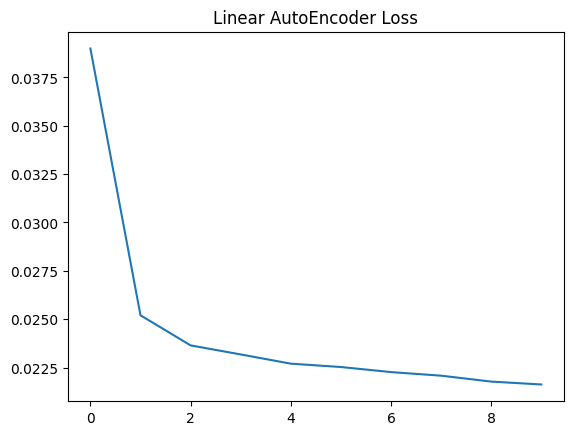

In [11]:
plt.plot([i.cpu().detach() for i in batch_train_losses])
plt.title("Linear AutoEncoder Loss")

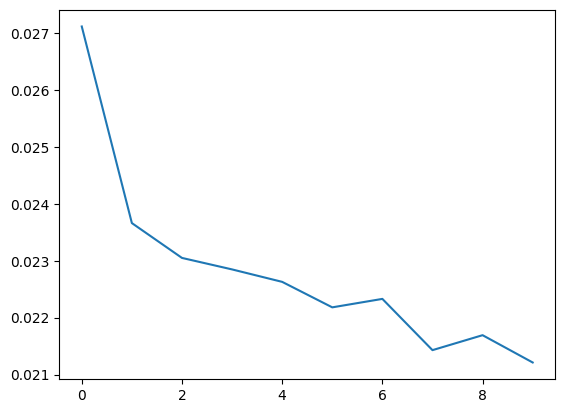

In [12]:
plt.plot([i.cpu().detach() for i in batch_test_losses])

In [13]:
autoencoder0.eval()

img = next(iter(test_DataLoader))[0][0]

with torch.no_grad():
    output = autoencoder0(img.to(device=device))

output.shape

torch.Size([1, 784])

In [14]:
output = torch.reshape(input=output, shape=(1, 28, 28))
output.shape

torch.Size([1, 28, 28])

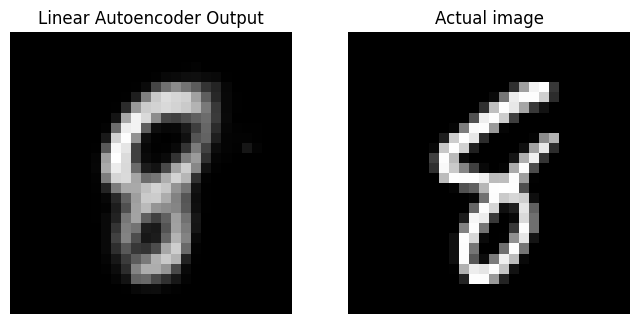

In [15]:
autoencoder0.eval()

img = next(iter(test_DataLoader))[0][0]

with torch.no_grad():
    output = autoencoder0(img.to(device=device))

output = torch.reshape(input=output, shape=(1, 28, 28))

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(output.cpu().squeeze().numpy(), cmap='gray')
ax[0].set_title("Linear Autoencoder Output")
ax[1].imshow(img.cpu().squeeze().numpy(), cmap='gray')
ax[1].set_title("Actual image")

ax[0].axis(False)
ax[1].axis(False)

plt.show()

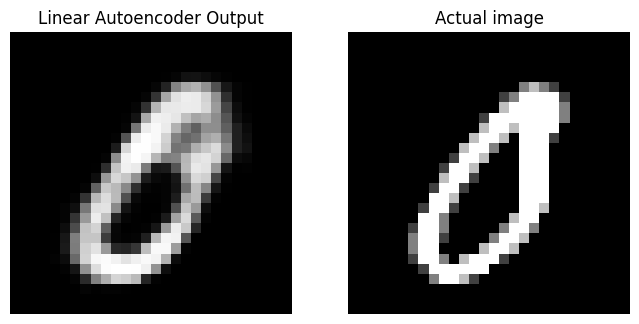

In [16]:
autoencoder0.eval()

img = next(iter(test_DataLoader))[0][0]

with torch.no_grad():
    output = autoencoder0(img.to(device=device))

output = torch.reshape(input=output, shape=(1, 28, 28))

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(output.cpu().squeeze().numpy(), cmap='gray')
ax[0].set_title("Linear Autoencoder Output")
ax[1].imshow(img.cpu().squeeze().numpy(), cmap='gray')
ax[1].set_title("Actual image")

ax[0].axis(False)
ax[1].axis(False)

plt.show()

A simple model, and a decent output

In [17]:
class ConvAutoEncoder(nn.Module):
    def __init__(self, in_channel, encoder_channel, middle_channel, decoder_channel):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=encoder_channel, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=encoder_channel, out_channels=encoder_channel*2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=encoder_channel*2, out_channels=middle_channel, kernel_size=7)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=middle_channel, out_channels=decoder_channel*2, kernel_size=7),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=decoder_channel*2, out_channels=decoder_channel, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=decoder_channel, out_channels=in_channel, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.decoder(self.encoder(x))
    
autoencoder1 = ConvAutoEncoder(in_channel=1, encoder_channel=16, middle_channel=64, decoder_channel=16)
autoencoder1.to(device=device)

autoencoder1, next(autoencoder1.parameters()).device, sum(torch.numel(i) for i in autoencoder1.parameters() if i.requires_grad)

(ConvAutoEncoder(
   (encoder): Sequential(
     (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (3): ReLU()
     (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
   )
   (decoder): Sequential(
     (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
     (1): ReLU()
     (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
     (3): ReLU()
     (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
     (5): Sigmoid()
   )
 ),
 device(type='mps', index=0),
 210369)

In [18]:
summary(model=autoencoder1, input_size=(1, 28, 28), col_names=["input_size", 'output_size', 'num_params', 'trainable'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ConvAutoEncoder                          [1, 28, 28]               [1, 28, 28]               --                        True
├─Sequential: 1-1                        [1, 28, 28]               [64, 1, 1]                --                        True
│    └─Conv2d: 2-1                       [1, 28, 28]               [16, 14, 14]              160                       True
│    └─ReLU: 2-2                         [16, 14, 14]              [16, 14, 14]              --                        --
│    └─Conv2d: 2-3                       [16, 14, 14]              [32, 7, 7]                4,640                     True
│    └─ReLU: 2-4                         [32, 7, 7]                [32, 7, 7]                --                        --
│    └─Conv2d: 2-5                       [32, 7, 7]                [64, 1, 1]                100,416                   True
├─Seque

In [19]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=autoencoder1.parameters(), lr=1e-2)

loss_fn, optimizer

(BCELoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     weight_decay: 0
 ))

In [20]:
%%time

from tqdm.auto import  tqdm

epochs = 10
batch_train_losses = []
batch_test_losses = []

autoencoder1.to(device=device)

for epoch in tqdm(range(epochs)):
    autoencoder1.train()
    train_losses = 0
    train_accuracies = 0
    test_losses = 0
    test_accuracies = 0

    for batch, (X, y) in enumerate(train_DataLoader):
        X = X.to(device=device)

        output = autoencoder1(X)
        loss = loss_fn(output, X)

        train_losses += loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch%100==0 and epoch%2==0:
            print(f"Batch {batch}, training batch loss: {loss}")

    train_losses /= len(train_DataLoader)
    batch_train_losses.append(train_losses)

    autoencoder1.eval()
    with torch.inference_mode():
        for X, y in test_DataLoader:
            X = X.to(device=device)

            output = autoencoder1(X)
            preds = torch.argmax(output, dim=1)

            loss = loss_fn(output, X)
            test_losses += loss

        test_losses /= len(test_DataLoader)
        batch_test_losses.append(test_losses)

    if epoch%2 == 0:
        print(f"Epoch: {epoch}, Train Loss: {train_losses}, Test Loss: {test_losses}")

  0%|          | 0/10 [00:00<?, ?it/s]

Batch 0, training batch loss: 0.7183266282081604
Batch 100, training batch loss: 0.17961256206035614
Batch 200, training batch loss: 0.1232573390007019
Batch 300, training batch loss: 0.10107347369194031
Batch 400, training batch loss: 0.0987892895936966
Batch 500, training batch loss: 0.08967529982328415
Batch 600, training batch loss: 0.09072074294090271
Batch 700, training batch loss: 0.08561825752258301
Batch 800, training batch loss: 0.07735125720500946
Batch 900, training batch loss: 0.0802101418375969
Batch 1000, training batch loss: 0.07997787743806839
Batch 1100, training batch loss: 0.07830697298049927
Batch 1200, training batch loss: 0.07560927420854568
Batch 1300, training batch loss: 0.0792037695646286
Batch 1400, training batch loss: 0.07868283241987228
Batch 1500, training batch loss: 0.08126888424158096
Batch 1600, training batch loss: 0.0712842047214508
Batch 1700, training batch loss: 0.07903140038251877
Batch 1800, training batch loss: 0.07529757916927338


 10%|█         | 1/10 [00:11<01:41, 11.31s/it]

Epoch: 0, Train Loss: 0.09805062413215637, Test Loss: 0.07412558794021606


 20%|██        | 2/10 [00:22<01:28, 11.10s/it]

Batch 0, training batch loss: 0.07251743972301483
Batch 100, training batch loss: 0.07451197504997253
Batch 200, training batch loss: 0.07188886404037476
Batch 300, training batch loss: 0.0707143247127533
Batch 400, training batch loss: 0.07283113896846771
Batch 500, training batch loss: 0.0684627965092659
Batch 600, training batch loss: 0.07138329744338989
Batch 700, training batch loss: 0.07401807606220245
Batch 800, training batch loss: 0.0736476331949234
Batch 900, training batch loss: 0.06772366911172867
Batch 1000, training batch loss: 0.06757327169179916
Batch 1100, training batch loss: 0.07305891811847687
Batch 1200, training batch loss: 0.0713396742939949
Batch 1300, training batch loss: 0.07568854838609695
Batch 1400, training batch loss: 0.07179217040538788
Batch 1500, training batch loss: 0.07242382317781448
Batch 1600, training batch loss: 0.07105102390050888
Batch 1700, training batch loss: 0.07374029606580734
Batch 1800, training batch loss: 0.07432308048009872


 30%|███       | 3/10 [00:33<01:17, 11.02s/it]

Epoch: 2, Train Loss: 0.07086893171072006, Test Loss: 0.06989846378564835


 40%|████      | 4/10 [00:43<01:05, 10.93s/it]

Batch 0, training batch loss: 0.06988471001386642
Batch 100, training batch loss: 0.06868824362754822
Batch 200, training batch loss: 0.06504341959953308
Batch 300, training batch loss: 0.06968868523836136
Batch 400, training batch loss: 0.07465420663356781
Batch 500, training batch loss: 0.07010921835899353
Batch 600, training batch loss: 0.06762512773275375
Batch 700, training batch loss: 0.06936806440353394
Batch 800, training batch loss: 0.0702008605003357
Batch 900, training batch loss: 0.07024025917053223
Batch 1000, training batch loss: 0.073341503739357
Batch 1100, training batch loss: 0.070689357817173
Batch 1200, training batch loss: 0.06820215284824371
Batch 1300, training batch loss: 0.0687156617641449
Batch 1400, training batch loss: 0.07006144523620605
Batch 1500, training batch loss: 0.06904887408018112
Batch 1600, training batch loss: 0.06855344027280807
Batch 1700, training batch loss: 0.06746804714202881
Batch 1800, training batch loss: 0.07110368460416794


 50%|█████     | 5/10 [00:54<00:54, 10.86s/it]

Epoch: 4, Train Loss: 0.06962134689092636, Test Loss: 0.06878534704446793


 60%|██████    | 6/10 [01:04<00:42, 10.65s/it]

Batch 0, training batch loss: 0.07265818864107132
Batch 100, training batch loss: 0.06889200210571289
Batch 200, training batch loss: 0.07021929323673248
Batch 300, training batch loss: 0.06608116626739502
Batch 400, training batch loss: 0.06426634639501572
Batch 500, training batch loss: 0.06559261679649353
Batch 600, training batch loss: 0.06805813312530518
Batch 700, training batch loss: 0.06914719939231873
Batch 800, training batch loss: 0.0699542686343193
Batch 900, training batch loss: 0.07594315707683563
Batch 1000, training batch loss: 0.06847614794969559
Batch 1100, training batch loss: 0.0696793720126152
Batch 1200, training batch loss: 0.07034553587436676
Batch 1300, training batch loss: 0.06726551800966263
Batch 1400, training batch loss: 0.07178845256567001
Batch 1500, training batch loss: 0.07083065062761307
Batch 1600, training batch loss: 0.0666009932756424
Batch 1700, training batch loss: 0.07014298439025879
Batch 1800, training batch loss: 0.06853359192609787


 70%|███████   | 7/10 [01:15<00:32, 10.75s/it]

Epoch: 6, Train Loss: 0.06907183676958084, Test Loss: 0.06851290911436081


 80%|████████  | 8/10 [01:26<00:21, 10.74s/it]

Batch 0, training batch loss: 0.0713178887963295
Batch 100, training batch loss: 0.07044722884893417
Batch 200, training batch loss: 0.06846356391906738
Batch 300, training batch loss: 0.06875023990869522
Batch 400, training batch loss: 0.06933178752660751
Batch 500, training batch loss: 0.07224205136299133
Batch 600, training batch loss: 0.0676397904753685
Batch 700, training batch loss: 0.07199328392744064
Batch 800, training batch loss: 0.06950196623802185
Batch 900, training batch loss: 0.06511685997247696
Batch 1000, training batch loss: 0.07551321387290955
Batch 1100, training batch loss: 0.06855446100234985
Batch 1200, training batch loss: 0.06537160277366638
Batch 1300, training batch loss: 0.07382208108901978
Batch 1400, training batch loss: 0.06735534220933914
Batch 1500, training batch loss: 0.07668836414813995
Batch 1600, training batch loss: 0.06941687315702438
Batch 1700, training batch loss: 0.06423171609640121
Batch 1800, training batch loss: 0.06660699099302292


 90%|█████████ | 9/10 [01:37<00:10, 10.70s/it]

Epoch: 8, Train Loss: 0.06872668117284775, Test Loss: 0.06794926524162292


100%|██████████| 10/10 [01:47<00:00, 10.76s/it]

CPU times: user 1min 38s, sys: 11.5 s, total: 1min 49s
Wall time: 1min 47s


Text(0.5, 1.0, 'Convolutional AutoEncoder Loss')

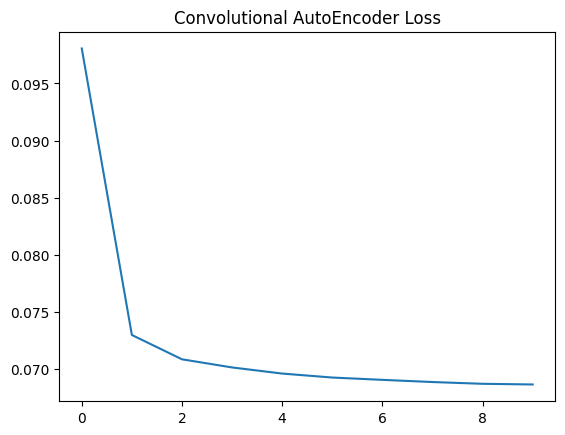

In [21]:
plt.plot([i.cpu().detach() for i in batch_train_losses])
plt.title("Convolutional AutoEncoder Loss")

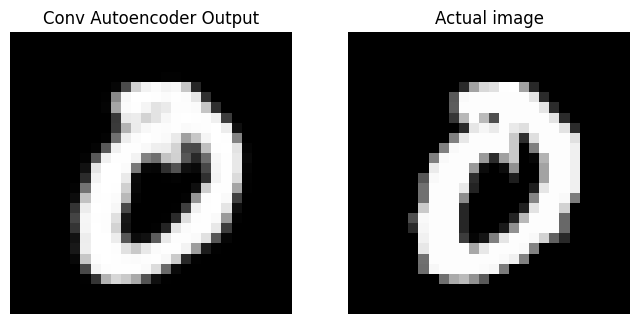

In [30]:
autoencoder1.eval()

img = next(iter(test_DataLoader))[0][0]

with torch.no_grad():
    output = autoencoder1(img.to(device=device))

output = torch.reshape(input=output, shape=(1, 28, 28))

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(output.cpu().squeeze().numpy(), cmap='gray')
ax[0].set_title("Conv Autoencoder Output")
ax[1].imshow(img.cpu().squeeze().numpy(), cmap='gray')
ax[1].set_title("Actual image")

ax[0].axis(False)
ax[1].axis(False)

plt.show()

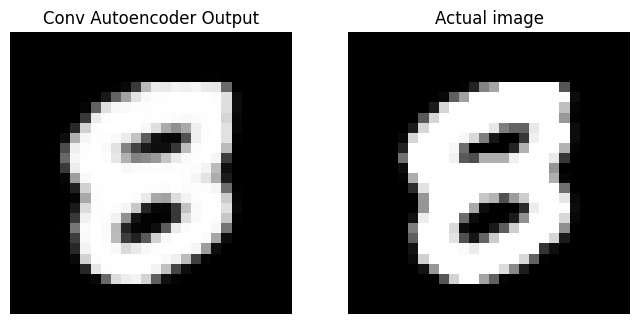

In [43]:
autoencoder1.eval()

img = next(iter(test_DataLoader))[0][0]

with torch.no_grad():
    output = autoencoder1(img.to(device=device))

output = torch.reshape(input=output, shape=(1, 28, 28))

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(output.cpu().squeeze().numpy(), cmap='gray')
ax[0].set_title("Conv Autoencoder Output")
ax[1].imshow(img.cpu().squeeze().numpy(), cmap='gray')
ax[1].set_title("Actual image")

ax[0].axis(False)
ax[1].axis(False)

plt.show()

Pretty realistic output